# SHAP or SHapley Additive exPlanations Tutorial #
This notebook is based on the youtube playlist/tutorial at:   https://www.youtube.com/playlist?list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK <br>
<br>
SHAP is the most powerful Python package for understanding and debugging your machine-learning models. We learn to interpret SHAP values for both continuous and binary target variables. We also explore the applications of SHAP. This includes debugging models, providing human-friendly 
explanations and data exploration. 

F-Score Can tell us how important features are to the model, but not:
  * Individual predictions
  * Increaded or decreased the prediction
  * Changed the probability of positive prediction (classification)
<br><br>
This is where SHAP comes in.  <br>

![Example](./SHAP_Summary.png "SHAP Values Summary")


### SHAP with Python Code and Explanations

In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

#### Load the Dataset ####
To demonstrate the SHAP package we will use an abalone dataset with 4,177 observations. Abalones are a shellfish delicacy. We want to use the dataset to predict their age. More specifically, our target variable is the number of rings in the abalone shell. We will be using features such as the shell length, shell diameter and the whole weight of the abalone.
The dataset comes from:  https://archive.ics.uci.edu/dataset/1/abalone.  This data source has been seen before and is a reliable source for datasets.

In [17]:
data = pd.read_csv("./data/abalone/abalone.data", names = ["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight", "rings"])
print(data.shape)
data

(4177, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


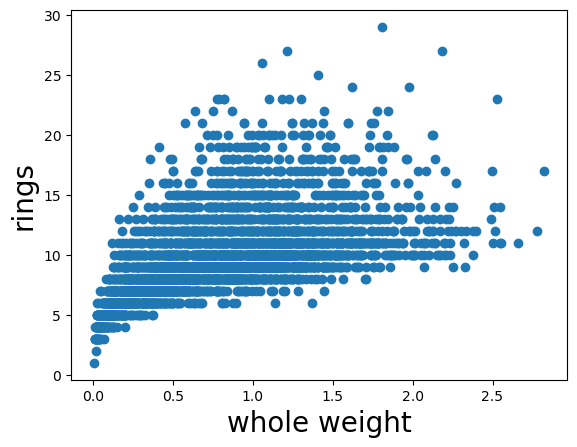

In [18]:
plt.scatter(data['whole_weight'], data['rings'])
plt.ylabel('rings', size=20)
plt.xlabel('whole weight', size = 20)
plt.show()

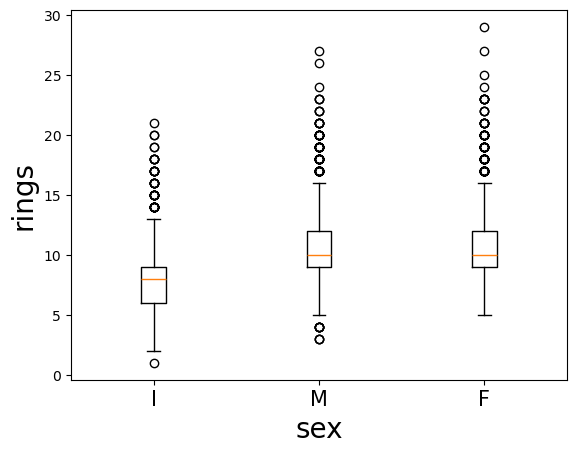

In [19]:
plt.boxplot(data[data.sex=='I']['rings'], positions =[1])
plt.boxplot(data[data.sex=='M']['rings'], positions =[2])
plt.boxplot(data[data.sex=='F']['rings'], positions =[3])

plt.xticks(ticks=[1,2,3], labels=['I','M','F'], size=15)
plt.ylabel('rings', size=20)
plt.xlabel('sex', size=20)
plt.show()

<Axes: >

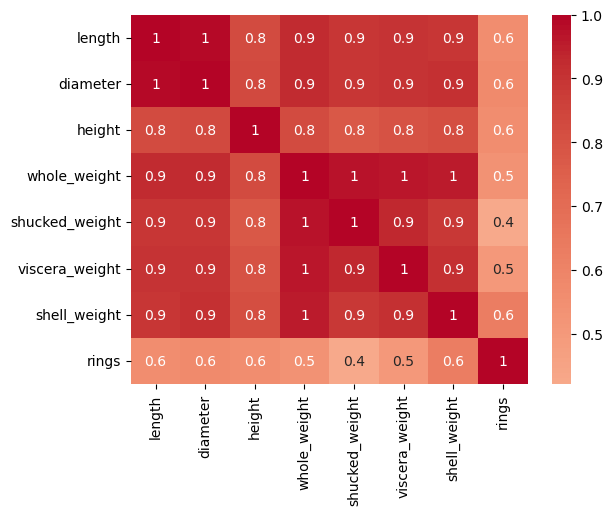

In [20]:
cont=['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

corr_matrix = pd.DataFrame(data[cont], columns = cont).corr()

sns.heatmap(corr_matrix, cmap ='coolwarm', center=0, annot=True, fmt='.1g')

#### Feature Engineering ####
* Drop `diameter` and `whole_weight` because they are directly correlated to other features (length and the other weights, respectively.)
* Turn the gender into a categorical feature using one's-hot encoding. Drop `sex` from the dataset.

In [21]:
# Extract the target variable:  Rings
y = data['rings']

# Reduce our input dataset to only these columns
x = data[['sex', 'length', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight']].copy()

In [22]:
# One's-Hot Encoding for the categorical feature: Sex
x['sex.M']= [1 if s =='M' else 0 for s in x['sex']]
x['sex.F']= [1 if s =='F' else 0 for s in x['sex']]
x['sex.I']= [1 if s =='I' else 0 for s in x['sex']]

x = x.drop('sex', axis=1)
x

,length,height,shucked_weight,viscera_weight,shell_weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.1500,1,0,0
1,0.350,0.090,0.0995,0.0485,0.0700,1,0,0
2,0.530,0.135,0.2565,0.1415,0.2100,0,1,0
3,0.440,0.125,0.2155,0.1140,0.1550,1,0,0
4,0.330,0.080,0.0895,0.0395,0.0550,0,0,1
...,...,...,...,...,...,...,...,...
4172,0.565,0.165,0.3700,0.2390,0.2490,0,1,0
4173,0.590,0.135,0.4390,0.2145,0.2605,1,0,0
4174,0.600,0.205,0.5255,0.2875,0.3080,1,0,0
4175,0.625,0.150,0.5310,0.2610,0.2960,0,1,0


In [26]:
y

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: rings, Length: 4177, dtype: int64

#### Modeling ####
We will build an xgBoost Regressor to predict the number of rings using our selected feature set.<br>
<br>
It is worth noting that we are only trying to demonstrate SHAP.  This model bypasses best practices like using a training/validation/test split, any advanced feature engineering, or any hyperparameter tuning.

In [23]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
y_pred = model.predict(x)
y_pred

array([12.421788 ,  7.8772216,  9.83445  , ...,  9.917346 ,  9.58463  ,
       11.798461 ], dtype=float32)

Text(0.5, 0, 'Actual')

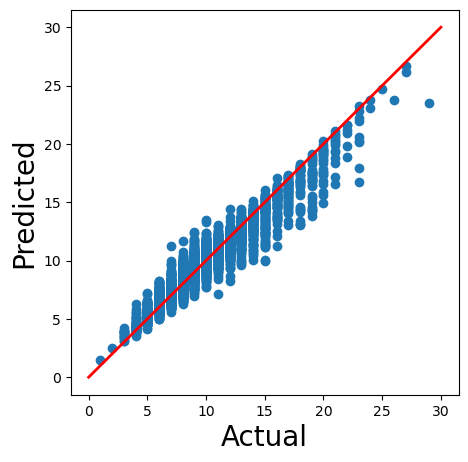

In [27]:
# Check the model evaluation
plt.figure(figsize=(5,5))
plt.scatter(y, y_pred)
plt.plot([0,30], [0,30], color='r', linestyle='-', linewidth=2)
plt.ylabel('Predicted', size=20)
plt.xlabel('Actual', size=20)

## 1) Standard SHAP Values

In [29]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(x)
shap_values

.values =
array([[ 0.36806285,  1.0587054 ,  0.94834965, ...,  0.3316413 ,
        -0.04919233,  0.3216473 ],
       [-0.7708986 , -0.21779695,  1.176285  , ...,  0.05278974,
        -0.0395156 ,  0.49588168],
       [ 0.15351889, -0.02277692,  0.47050092, ...,  0.04105941,
         0.04848656,  0.12317639],
       ...,
       [ 0.14958209,  0.32025054, -1.4478747 , ...,  0.04284297,
         0.01527823,  0.02549139],
       [-0.04009023, -0.09120232, -0.919325  , ...,  0.05648781,
         0.05737196,  0.09682811],
       [ 0.61490464,  0.388789  , -0.55129325, ...,  0.05122245,
         0.00867648,  0.07278913]], dtype=float32)

.base_values =
array([9.93266, 9.93266, 9.93266, ..., 9.93266, 9.93266, 9.93266],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 1.    , 0.    , 0.    ],
       [0.53  , 0.135 , 0.2565, ..., 0.    , 1.    , 0.    ],
       ...,
       [0.6   , 0.205 , 0.5255, ..., 1.    , 0.    

In [30]:
np.shape(shap_values.values)

(4177, 8)

#### Waterfall Plot of SHAP Values

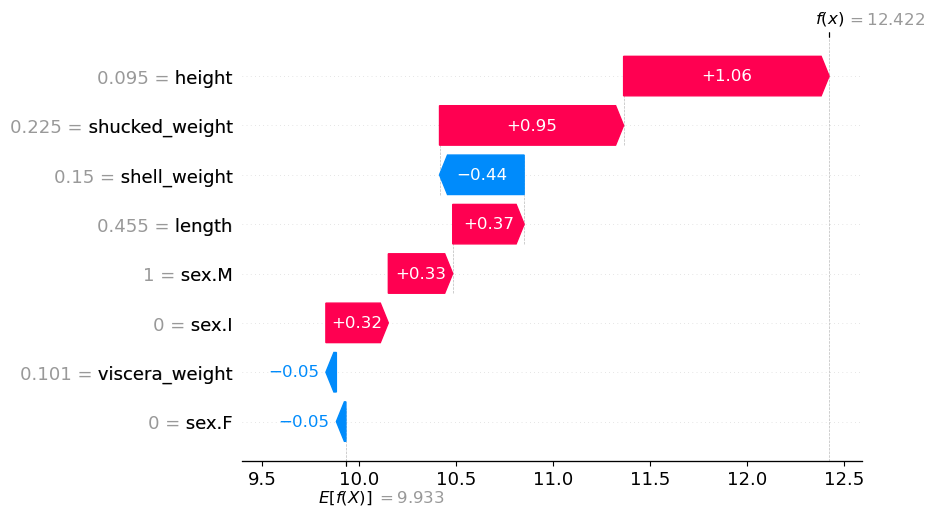

In [31]:
shap.plots.waterfall(shap_values[0])

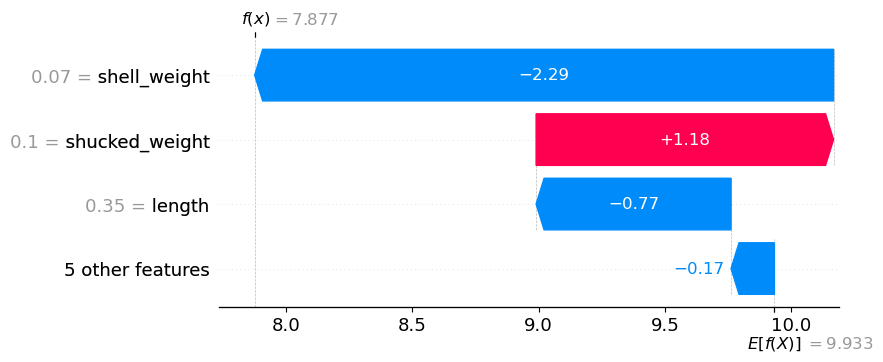

In [32]:
shap.plots.waterfall(shap_values[1], max_display=4)

#### Force Plot

In [33]:
shap.plots.force(shap_values[0])

#### Stacked Force Plot

In [34]:
shap.plots.force(shap_values[0:100])

#### Absolute Mean SHAP

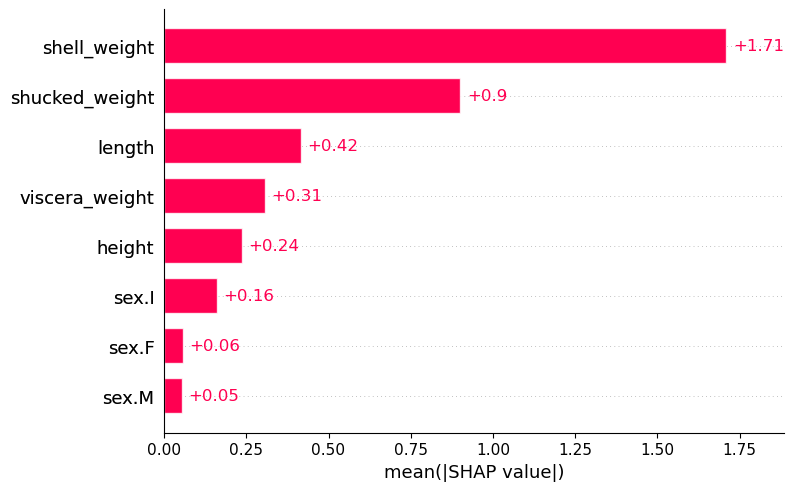

In [35]:
shap.plots.bar(shap_values)

#### Beeswarm Mean SHAP

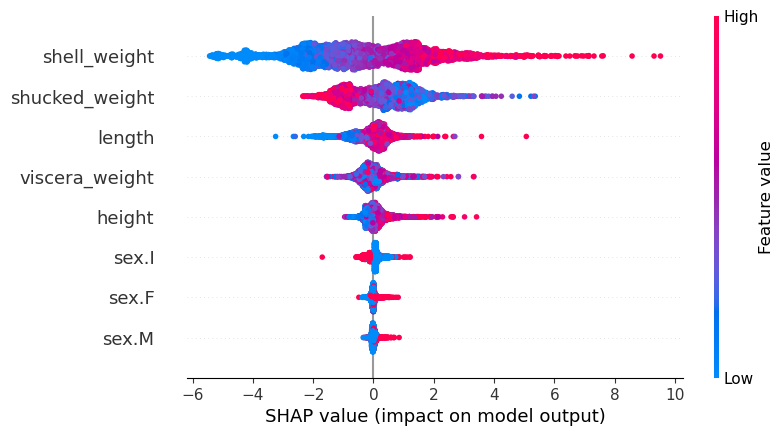

In [38]:
shap.plots.beeswarm(shap_values)

#### Dependency Plots

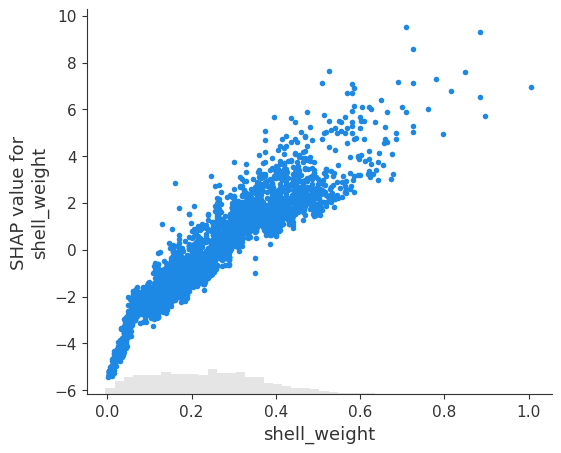

In [39]:
# Plot 1: shell weight
shap.plots.scatter(shap_values[:,"shell_weight"])

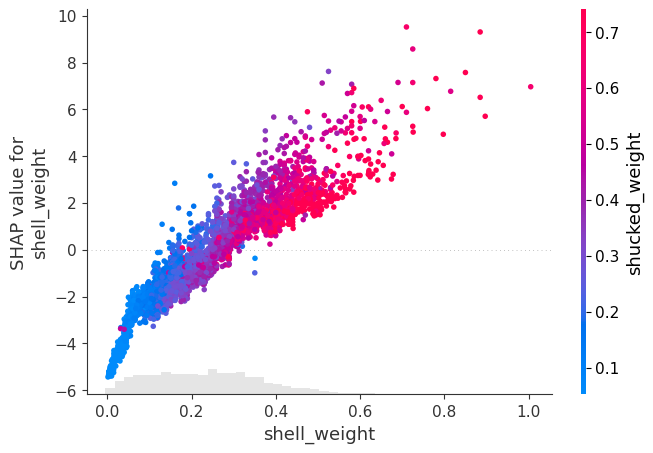

In [40]:
shap.plots.scatter(shap_values[:,"shell_weight"], color=shap_values[:,"shucked_weight"])

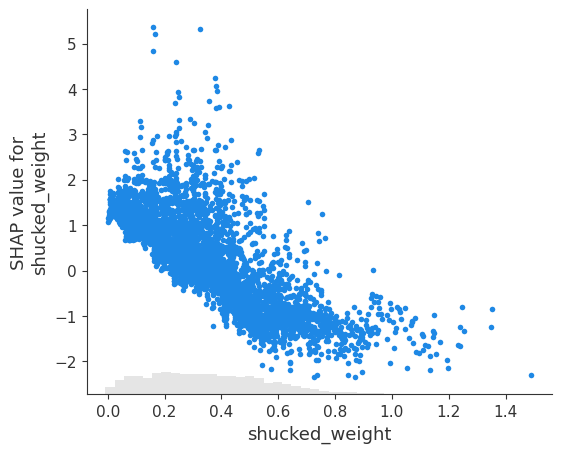

In [41]:
# Plot 2: shucked weight
shap.plots.scatter(shap_values[:,'shucked_weight'])

#### "New" Heatmap SHAP Plot ####
This can be used to see trends.  For example, look at the shucked weight feature in the second graph.  There are 2 clusters of high impact SHAP values at either end of the F(x) ordering.

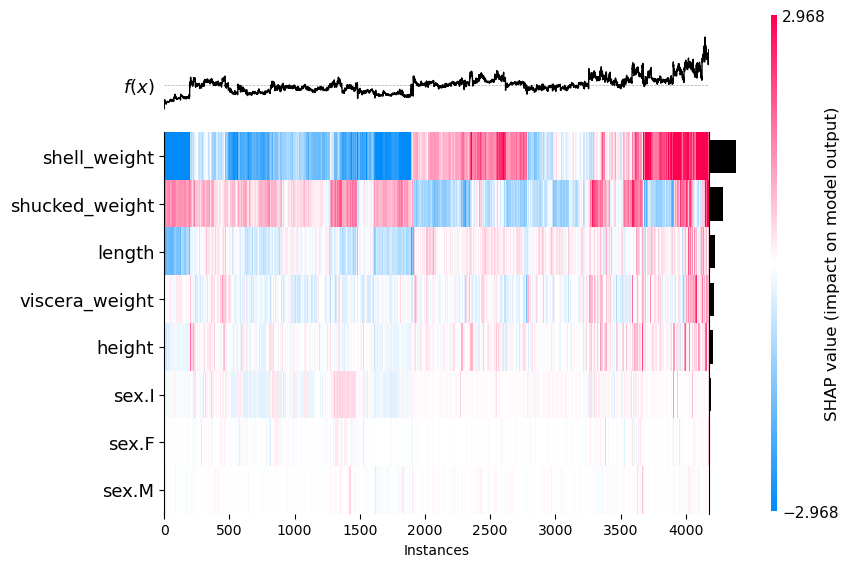

<Axes: xlabel='Instances'>

In [42]:
# Caution this takes a little while (approx 1 minute for this small dataset)
shap.plots.heatmap(shap_values)

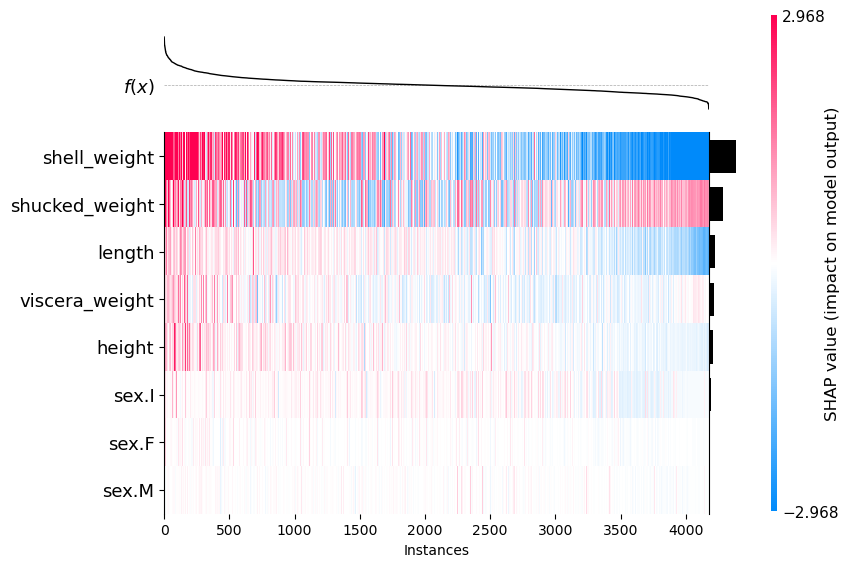

<Axes: xlabel='Instances'>

In [45]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

#### Monitoring SHAP Plot

In [44]:
features = ['length', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight']
shap.plots.monitoring(0, shap_values, features)

ValueError: data type <class 'numpy.object_'> not inexact

<Figure size 1000x300 with 0 Axes>

#### SHAP for binary target variables

In [ ]:
y_bin